# Testing asymmetry on real data

## Fetching a sample

We can test on a sample of HST-SPOGs, since we know they have SDSS and HST data. Would also like to see if they haave UNIONS and HSC coverage.

In [1]:
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm 
from astropy.wcs import WCS

from astropy.visualization import AsinhStretch, AsymmetricPercentileInterval, LogStretch
stretch = AsinhStretch(0.6)
norm    = AsymmetricPercentileInterval(10, 99.7)

In [2]:
# plt.rcParams['image.interpolation'] = 'None'

Load in the dataset containing HST-SPOG ids, coordinates, and their control samples. This is already cross-matched with HST and SDSS.

In [3]:
data = pd.read_csv('data/catalogs/data.csv')
data.head(3)

,name,ra,dec,lmass50,z,dataset,cfis,hsc
0,J000318+004844,0.825888,0.812301,10.820000,0.138889,spog,False,True
1,J001145-005431,2.938389,-0.908503,10.221996,0.047883,spog,False,True
2,J002232+002127,5.632805,0.357513,10.150000,0.047105,control_sfg,False,True


### UNIONS
The deepest is CFIS r-band data, so that's what we use.

There are ID matches with UNIONS (selected by hand...) - they all have CFIS-r data.

In [4]:
# # From inspecting the cutouts service
# ids = [9,12,13,14,18,23,24,25,26,30,31,33,34,35,37,39,45,47,50,53,55,56,57,58,59,60,63,67,68,69,70,71,72,73]
# # ids = [ 9, 12, 13, 14, 18, 23, 24, 25, 26, 30, 31, 34, 35, 56, 57, 58, 59,
# #        60, 67, 68, 69, 70, 71, 72, 73, 27, 32, 36, 38, 40, 46, 48, 51, 54,
# #        61, 64]
# # ids2 = [27, 32, 36, 38, 40, 46, 48, 51, 54, 61, 64]

# # Save these as unions-detected
# data['cfis'] = False
# data.loc[ids, 'cfis'] = True

### HSC

This is i-band data.

Now use the HSC cutout service to see which galaxies have HSC data. For this, we need a tab-delimited table with just `name`, `ra`, and `dec`, and the header should begin with `#? `.

In [5]:
hsc_cutouts = data[['ra','dec']].copy()
hsc_cutouts.to_csv('data/catalogs/hsc_cutouts_lookup.csv',index=False,sep='\t')

# hsc_data = ! ls data/hsc/
# hsc_data = [name[:-5] for name in hsc_data]
# data['hsc'] = False
# data.loc[data["name"].isin(hsc_data), "hsc"] = True

In [6]:
data[data.hsc]

,name,ra,dec,lmass50,z,dataset,cfis,hsc
0,J000318+004844,0.825888,0.812301,10.820000,0.138889,spog,False,True
1,J001145-005431,2.938389,-0.908503,10.221996,0.047883,spog,False,True
2,J002232+002127,5.632805,0.357513,10.150000,0.047105,control_sfg,False,True
10,J085357+031034,133.486704,3.175993,11.000000,0.129185,spog,False,True
19,J095750-001239,149.456404,-0.210907,10.170000,0.033022,spog,False,True
20,J095752+022908,149.465700,2.485481,10.390000,0.091566,control_qg,False,True
21,J095757+020656,149.488404,2.115574,10.610000,0.125197,control_sfg,False,True
22,J095800+022811,149.497700,2.469590,10.600000,0.119431,control_sfg,False,True
23,J095853+022603,149.720006,2.434196,10.870000,0.125027,control_qg,True,True
24,J095859+021500,149.743904,2.249749,10.960000,0.132862,control_sfg,True,True


### HST-SDSS-HSC cutouts

In [7]:
f = fits.open(f'data/hst/F814W/J001145-005431.fits')

/var/folders/_w/6csvq9qx0611l8s_lvbrrpyh0000gn/T/ipykernel_40168/3501114940.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(-2.5*np.log10(np.abs(tmp[0].data/tmp[0].header['pxscale']**2))+tmp[0].header['zp'], cmap='gray_r', vmin=20, vmax=30)


(550.0, 1550.0)

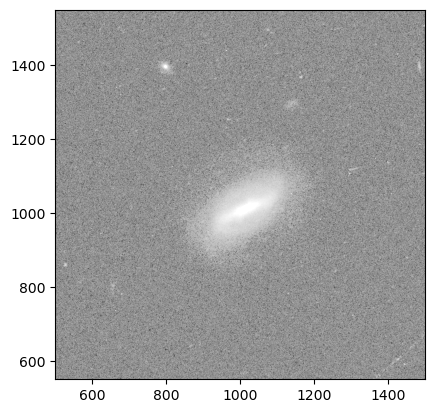

In [8]:
ex = 'J001145-005431'
tmp = fits.open(f'data/hst/F814W/{ex}.fits')

plt.imshow(-2.5*np.log10(np.abs(tmp[0].data/tmp[0].header['pxscale']**2))+tmp[0].header['zp'], cmap='gray_r', vmin=20, vmax=30)
plt.xlim(500,1500)
plt.ylim(550,1550)

In [9]:
def make_cutout(row):
    
    sdss_file = fits.open(f'data/sdss/i/{row["name"]}.fits')
    sdss_wcs = WCS(sdss_file[0].header)
    
    # SDSS
    sdss_img = -2.5*np.log10(1e-9*np.abs(sdss_file[0].data) / 0.396**2)
    
    # HST
    hst_file = fits.open(f'data/hst/F814W/{row["name"]}.fits')
    hst_wcs = WCS(hst_file[0].header)
    hst_img = -2.5*np.log10(np.abs(hst_file[0].data) / hst_file[0].header['pxscale']**2) + hst_file[0].header['zp']
    
    # HSC
    hsc_file = fits.open(f'data/hsc/{row["name"]}.fits')
    hsc_img = -2.5*np.log10(np.abs(hsc_file[0].data) / hsc_file[0].header['FLUXMAG0'] / 0.168**2 )
    hsc_wcs = WCS(hsc_file[1].header)

    # Define image size
    size = 20/0.396
    cent = 40/0.396
    
    # Make axes
    fig = plt.figure(figsize=(13,4))
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
    
    # Plot the three subplots
    imgs = [sdss_img, hst_img, hsc_img]
    wcss = [sdss_wcs, hst_wcs, hsc_wcs]
    labels = ['SDSS', 'HST', 'HSC']
    axs = []
    for i, (img, wcs, label) in enumerate(zip(imgs, wcss, labels)):
        # Plot the galaxy
        ax = fig.add_subplot(1,3,i+1, projection=sdss_wcs)
        axs.append(ax)
        im = ax.imshow(img, cmap='gray_r', vmin=20, vmax=28, transform=ax.get_transform(wcs))
        ax.set_xlim(cent-size, cent+size)
        ax.set_ylim(cent-size, cent+size)
        ax.axis('off')
        
        # Add a label
        color = 'w' if np.sum(img[:50,:50]) > 1000 else 'k'
        ax.annotate(label, xy=(0.03, 0.97), xycoords='axes fraction', color=color, size=16, va='top')
        
    for f in [sdss_file, hst_file, hsc_file]:
        f.close()

    # Add galaxy name
    axs[0].annotate(row['name'], xycoords='axes fraction', xy=(0.03, 0.03), va='bottom', ha='left', color='w', size=16)
    
    # Add a colorbar
    plt.subplots_adjust(wspace=0.01, hspace=0.01, left=0, bottom=0, top=1, right=0.94)
    cax = fig.add_axes([0.955, 0, 0.015, 1])
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label(r'SB [mag/arcsec$^2$]', size=14)
    
    return fig

In [10]:
sample = data[data.hsc]

for idx, row in tqdm(sample.iterrows(), total=len(sample)): 
    fig = make_cutout(row)
    plt.savefig(f'figures/hst_sdss_hsc/{row["name"]}.png', bbox_inches='tight')
    plt.close(fig)


  0%|          | 0/30 [00:00<?, ?it/s]

/var/folders/_w/6csvq9qx0611l8s_lvbrrpyh0000gn/T/ipykernel_40168/4272238348.py:12: RuntimeWarning: divide by zero encountered in log10
  hst_img = -2.5*np.log10(np.abs(hst_file[0].data) / hst_file[0].header['pxscale']**2) + hst_file[0].header['zp']
/var/folders/_w/6csvq9qx0611l8s_lvbrrpyh0000gn/T/ipykernel_40168/4272238348.py:12: RuntimeWarning: divide by zero encountered in log10
  hst_img = -2.5*np.log10(np.abs(hst_file[0].data) / hst_file[0].header['pxscale']**2) + hst_file[0].header['zp']
/var/folders/_w/6csvq9qx0611l8s_lvbrrpyh0000gn/T/ipykernel_40168/4272238348.py:7: RuntimeWarning: divide by zero encountered in log10
  sdss_img = -2.5*np.log10(1e-9*np.abs(sdss_file[0].data) / 0.396**2)
